# Lab 6: Learning Word Embeddings

## What We're Building

This notebook uses a very simple neural network to teach machines to understand **word meaning** by analyzing how words appear together in context. We use **Skip-Gram with Negative Sampling (SGNS)** (the algorithm that powered **Word2Vec**) to transform words into vectors that capture semantic relationships.

## Pipeline Overview

```
📜 Captions from the Visual Genome dataset (a large text corpus)
    ↓
🔗 Word Co-occurrence Network (which words appear together?)
    ↓
🎯 Skip-Gram Neural Network (learn context-based representations)
    ↓
✨ Word Embeddings (numerical vectors that capture meaning)
```

## What Makes This Special?

Unlike ChatGPT or modern transformers that predict the *next* "token", Skip-Gram learns by predicting **surrounding context**. Given a word like "dog," it learns to predict "brown," "running," "park" (words that typically appear nearby).

The magic? Words used in similar contexts end up with similar vectors:
- **king** - **man** + **woman** ≈ **queen**
- **red**, **blue**, **green** cluster together
- **walking** is closer to **running** than to **chair**

## Why It Matters

These embeddings become the foundation for:
- 🔍 Search engines understanding query meaning
- 🤖 Chatbots grasping context
- 📊 Clustering and classification tasks
- 🧩 Solving word analogies

By the end, you'll train embeddings from 5 million image descriptions and visualize how language naturally organizes itself in vector space!

In [1]:
# ============================================================================
# Imports
# ============================================================================

# lab2: Network construction and visualization
# lab6: Data preparation and embedding training

from lab6 import prepare_visual_genome_text, train_embeddings
from lab2 import process_text_network, visualize_network

/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 📚 Dataset: Visual Genome Region Descriptions

![Visual Genome example: region descriptions and scene graph](https://www.researchgate.net/publication/301844872/figure/fig30/AS:962204379660310@1606418809923/An-example-image-from-the-Visual-Genome-dataset-We-show-3-region-descriptions-and-their.gif)

## What is Visual Genome?

[Visual Genome](https://visualgenome.org/) is a large-scale dataset that pairs images with detailed text descriptions. It contains **~108K images** with **~5.4M region descriptions** — short phrases describing specific parts of each image.

**For this lab:** We use **only the text captions**, treating them as a large natural language corpus. We never process the images themselves. The graphic above simply shows where these captions come from.

---

## Why These Captions Work Well for Embeddings

- 🗣️ **Natural everyday language** — objects, colors, actions, relationships (*"man wearing blue shirt"*)
- 🔗 **Strong co-occurrence patterns** — words that belong together appear together frequently
- 🌍 **Diverse contexts** — indoor/outdoor scenes, people, animals, objects, activities
- 📈 **Large scale** — millions of phrases provide robust statistical signal

---

## Example Captions

```
a man wearing a blue shirt
red car parked on the street
woman holding a white umbrella
large tree behind a building
```

---

## What We'll Do
}

No image processing required — just pure text analysis!

In [8]:
# ============================================================================
# Step 1: Download and Prepare Text Data
# ============================================================================
# This downloads the Visual Genome region descriptions (JSON), extracts it,
# and converts all captions into a single plain text file for processing.
# Output: vg_text.txt (~80MB of text)

zip_url = "https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/region_descriptions.json.zip"
text_file = prepare_visual_genome_text(zip_url)

print(f"\n✓ Text data ready: {text_file}")

File vg_text.txt already exists. Skipping processing.

✓ Text data ready: vg_text.txt


In [3]:
# ============================================================================
# Step 2: Build Word Co-occurrence Network (will take a few minutes)
# ============================================================================
# Using your process_text_network() function from Lab 2
# This tokenizes the text, counts word co-occurrences, and builds a network
# where nodes are words and edges connect words that appear near each other.
#
# rare_threshold: Filters out uncommon words (keeps top ~0.025% by frequency)
# This gives us ~500 most common words to work with.

print("\n" + "="*80)
print("BUILDING TEXT NETWORK")
print("="*80)

network_data = process_text_network(
    text_file,
    rare_threshold=0.00025,  # Keep only very common tokens
    verbose=True
)

print(f"\n✓ Network built: {network_data['graph'].number_of_nodes():,} nodes, "
      f"{network_data['graph'].number_of_edges():,} edges")


BUILDING TEXT NETWORK
Loaded text: 154198751 characters
Tokenized: 33662585 tokens
Sample tokens: ['monkeys', 'waterbirds', 'bouye', 'barometer', 'hottie', 'popsicle', 'jersey', 'puffing', 'hideously', 'keywoard', 'toether', 'baloons', 'mantel', 'cumulus', 'aginst', 'infielder', 'slugs', 'awarua', 'specializing', 'sauser']
Replaced 62380 rare tokens (threshold=0.00025)
Final vocabulary: 458 unique tokens
Sample tokens: ['lot', 'eye', 'flag', 'knife', 'bottle', 'mountains', 'license', 'base', 'sleeve', 'stand', 'rock', 'sign', 'stone', 'area', 'body', 'brown', 'lettering', 'court', 'bench', 'vehicle']
Graph: 458 nodes, 50128 edges
Top tokens by frequency:
   1. '.' (freq=6085975)
   2. '<RARE>' (freq=4416304)
   3. 'a' (freq=2220903)
   4. 'the' (freq=2155082)
   5. 'on' (freq=1396037)
   6. 'of' (freq=980462)
   7. 'is' (freq=787911)
   8. 'in' (freq=714868)
   9. 'white' (freq=652421)
  10. 'black' (freq=398632)

✓ Network built: 458 nodes, 50,128 edges



VISUALIZING THE WORD GRAPH


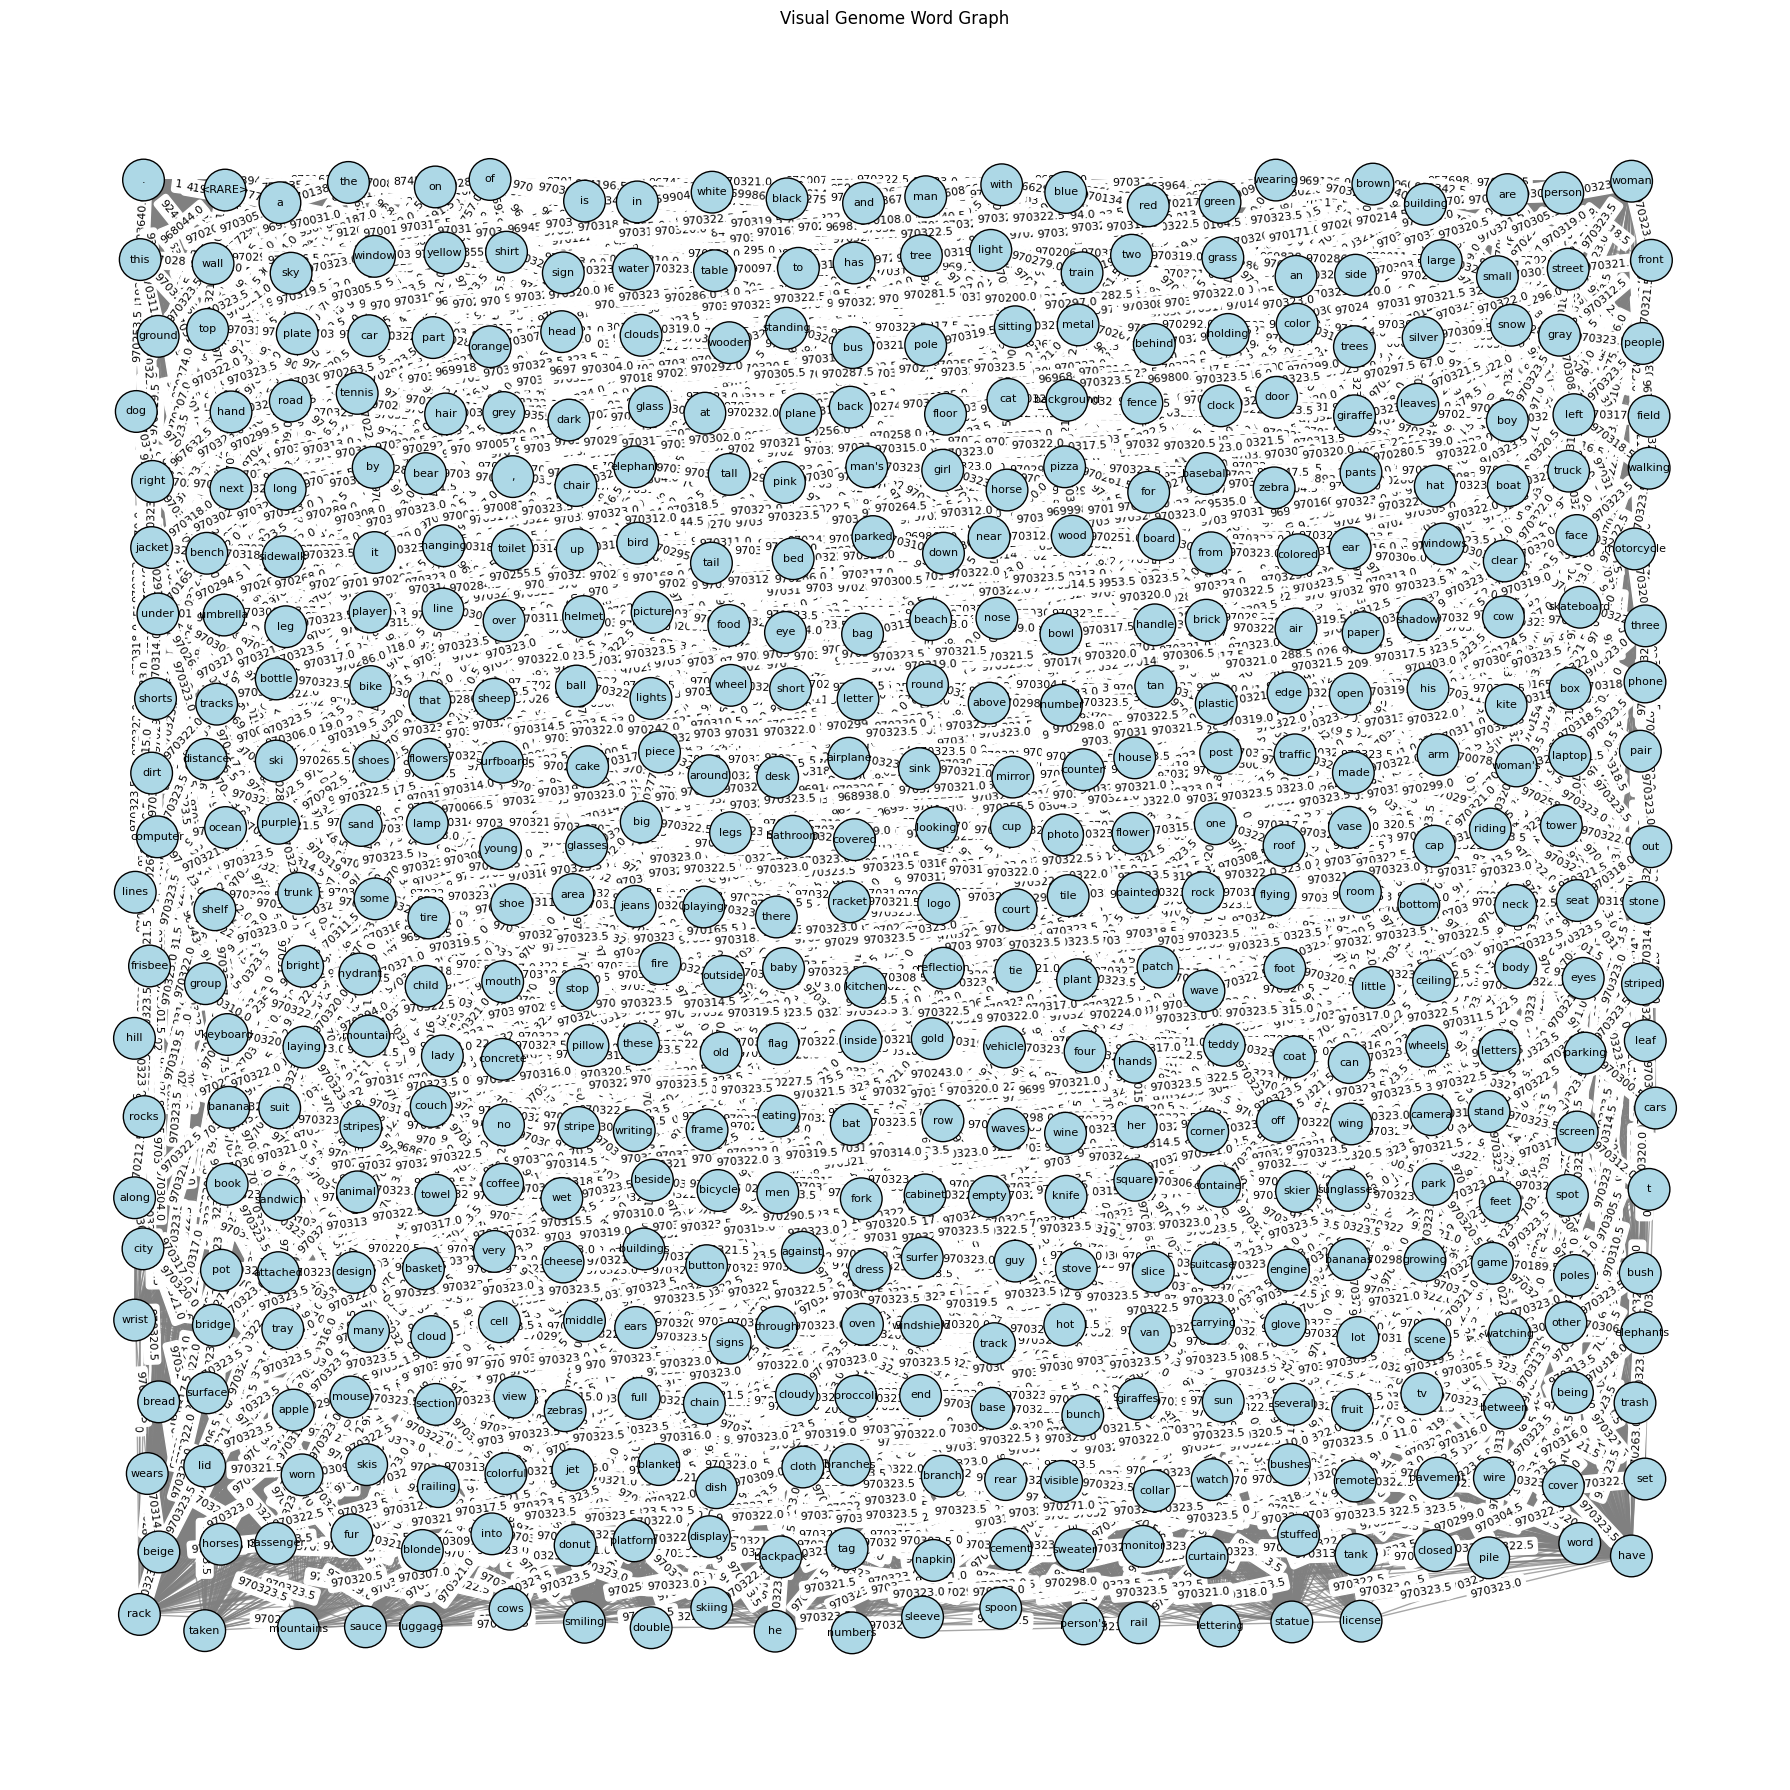


✓ Word graph visualization complete!


In [ ]:
# ============================================================================
# Step 3: Visualize the WORD GRAPH (OPTIONAL - SKIP IF SHORT ON TIME)
# ============================================================================
# ⚠️ WARNING: This visualization can take 10-15+ minutes to run!
#
# This uses the visualize_network() function from Lab 2 to create a
# layout of the word graph.
#
# Feel free to SKIP this cell and proceed directly to training.

print("\n" + "="*80)
print("VISUALIZING THE WORD GRAPH")
print("="*80)

all_labels = {node: node for node in network_data['graph'].nodes()}
visualize_network(
    G=network_data['graph'],
    distance_matrix=network_data['distance_matrix'],
    nodes=network_data['nodes'],
    node_labels=all_labels,
    title=f"Visual Genome Word Graph",
    figsize=(18, 18)
)

print("\n✓ Word graph visualization complete!")

## How We'll Train Our Network Embeddings

Now that you've seen the complete code, let's review the big picture. We're using PyTorch, a deep learning framework, to build and train our model. The whole process fits together like this:

```
📦 Dataset  →  🔄 DataLoader  →  🧠 Model  →  📈 Training Loop
```

The two key classes you just saw, **`SkipGramDataset`** and **`SkipGramModel`**, handle all the core logic for this.

-----

## The Big Picture: From Graphs to Embeddings

In a standard Skip-Gram model, the "context" is just the words nearby in a sentence. Our model is more advanced: **our context comes from the network graph.**

  * **Center Word:** A node in the graph (e.g., `"dog"`)
  * **Context Word:** A node connected by an edge (e.g., `"runs"`)

The training process (which you'll run next) follows this flow:

```
Network Data (word graph)
    ↓
SkipGramDataset
    • Takes word pairs from graph: (center, context_neighbor)
    • Samples negative examples (random words NOT in context)
    • Returns: (center, context, [neg₁, neg₂, ..., negₖ])
    ↓
DataLoader (batches data using WeightedRandomSampler)
    ↓
SkipGramModel
    • Embeddings: center words → vectors
    • Embeddings: context words → vectors
    • Compute similarity scores
    • Loss: maximize score for real neighbors, minimize for negatives
    ↓
Backpropagation (update embeddings)
    ↓
Repeat until convergence
```

-----

## Key Features in the Code

The code you just saw has three key features. Here’s *why* they are so important.

### 1\. Why Negative Sampling?

**Problem:** Our vocabulary has thousands of words. For the center word `"dog"`, calculating the probability for *every other word* (e.g., "cat", "runs", "airplane", "purple"...) to be its context is extremely slow.

**Solution:** We change the problem. Instead of "predict the context word," we ask a simpler, binary question:

  * ✅ **Positive Example:** Is `"runs"` (a real neighbor) in the context of `"dog"`? → **Train to output YES (score ≈ 1)**
  * ❌ **Negative Example:** Is `"airplane"` (a random word) in the context of `"dog"`? → **Train to output NO (score ≈ 0)**
  * ❌ **Negative Example:** Is `"purple"` (a random word) in the context of `"dog"`? → **Train to output NO (score ≈ 0)**

This is **Negative Sampling**. By training the model to distinguish between 1 positive example and \~15 negative ones (`num_negative=15`), we get a massive speedup and still learn high-quality embeddings.

### 2\. Why Weighted Sampling?

**Problem:** Not all neighbors are equally important. A pair like `("man", "walking")` might be very common and meaningful, while `("man", "street")` is also common but maybe less specific.

**Solution:** We use `WeightedRandomSampler` in the `train_embeddings` function. This sampler uses the **weights** from our `SkipGramDataset`, which are based on the `distance_matrix` (co-occurrence frequency).

This forces the training loop to **pay more attention to strong, frequent pairs**, sampling them more often and learning their relationship better.

### 3\. Why Filter Punctuation?

**Problem:** You saw the `filter_punctuation_from_network` function. Why bother?

**Solution: Hub Poisoning.** Think about the word `"."` (a period). It's a "neighbor" to the last word of *every single sentence*. This makes it a massive, meaningless "hub" that connects thousands of unrelated words.

If we left punctuation in, the model would waste most of its effort learning that "everything is related to a period." By removing it, we force the model to learn *actual semantic relationships* between words.

-----

## What's Next?

Now that you understand the "what" and the "why," it's time to put it all together. In the following cells, you will:

1.  **Load** the text data and **build** the network.
2.  **Run** the `train_embeddings` function to train your model.
3.  **Analyze** the resulting embeddings to see what the model learned\!

# 🛠️ Implementation Guide: What You'll Build

You will implement the two core PyTorch classes we just reviewed. The skeletons are provided in lab6.py.

## Part 1: `SkipGramDataset` (Data Preparation)

### Purpose

A PyTorch `Dataset` is responsible for fetching and preparing individual training examples. Our `Dataset` will convert our **graph** into `(center, context, negatives)` triples.

### Class Structure

```python
class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, graph, nodes, distance_matrix, num_negative=15, context_size=1):
        # Setup: build vocabulary, create training pairs, prepare negative sampling
        
    def __len__(self):
        # Return: total number of training examples
        
    def __getitem__(self, idx):
        # Return: (center_idx, context_idx, negative_indices)
```

### What You'll Implement

**`__init__` (Setup)**

  * Create a mapping: `self.node_to_idx` (e.g., "dog" → 42).
  * Build `self.contexts`: For each word, find its neighbors within `context_size` hops in the `graph`.
  * Generate `self.pairs` and `self.weights`: Create a list of all `(center, context)` pairs and use the `distance_matrix` to create a sampling weight for each pair.

**`__len__`** (Easy\!)

  * Return the total number of positive training pairs.

**`__getitem__` (Core Logic)**

  * Get the `(center_idx, context_idx)` pair for the given `idx`.
  * Sample `num_negative` random word indices from the entire vocabulary.
  * **Crucial Step:** Your negative samples must **exclude** the `center_idx` and *all* of its context words (use `self.contexts` to check).
  * Return the `center_idx`, `context_idx`, and the array of `negatives` as integer types (e.g., `np.int64`).

-----

## Part 2: `SkipGramModel` (The Neural Network)

### Purpose

A PyTorch `nn.Module` is your neural network. It defines the architecture (the "layers") and the `forward` pass (how data flows through it to compute a loss).

### Class Structure

```python
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout=0.3):
        # Setup: create embedding layers and dropout
        
    def forward(self, center, context, negatives, apply_dropout=True, label_smoothing=0.1):
        # Compute loss for this batch
        # Return: batch of loss values
```

### What You'll Implement

**`__init__` (Architecture)**

  * Create **two** embedding layers (`nn.Embedding`):
      * `self.center_embeddings`: (vocab\_size, embedding\_dim)
      * `self.context_embeddings`: (vocab\_size, embedding\_dim)
  * Create a `self.dropout` layer (`nn.Dropout`).
  * Call `self._init_embeddings()` to initialize the weights.

**`forward` (The Core Logic)**

This is where you'll compute the loss. You need to implement these steps:

1.  **Look up Embeddings:**

      * Get the `center_emb` vector(s) from `self.center_embeddings`.
      * Get the `context_emb` vector(s) from `self.context_embeddings`.
      * Get the `negative_emb` vectors from `self.context_embeddings`.

2.  **Apply Regularization:**

      * Apply the `self.dropout` layer to `center_emb` (but only if `apply_dropout` is `True`).

3.  **Compute Scores (Dot Products):**

      * `pos_score`: Compute the dot product between `center_emb` and `context_emb`.
      * `neg_score`: Compute the dot products between `center_emb` and *all* of its `negative_emb` vectors. (Hint: `torch.bmm` is great for this).

4.  **Compute Loss (with Label Smoothing):**

      * This is the most important part. You **cannot** use a simple loss function.
      * You must implement the loss manually using `F.logsigmoid` as shown in the lecture.
      * Calculate the loss for the `pos_score` using the `label_smoothing` value (target is `1.0 - label_smoothing`).
      * Calculate the loss for the `neg_score` using the `label_smoothing` value (target is `0.0 + label_smoothing`).
      * The total loss is the *negative* sum of the positive loss and the negative loss.

### Key Insight

The model's goal is to make the `center_emb` vector similar to its `context_emb` and **dissimilar** from all `negative_emb` vectors. The **dropout** and **label smoothing** are crucial regularization techniques to prevent overfitting and help the model generalize better.

-----

Now you're ready to implement these classes. The skeleton code is provided below with `TODO`s marking what you need to fill in.

In [5]:
import os
from IPython.display import Image, display
from lab6 import train_embeddings

print("\n" + "="*80)
print("🚀 STARTING TRAINING RUN")
print("This may take a few minutes. We are running the full pipeline...")
print("="*80)

# --- Hyperparameters ---
# We're using a smaller dimension (64 for speed).
# A wide context_size (4) captures broader graph relationships.
# The batch size is large for GPU efficiency.
results = train_embeddings(
    network_data=network_data,
    embedding_dim=64,        # Dimension of the learned vectors
    batch_size=2048,         # Number of pairs per training step
    epochs=20,               # Max epochs (will stop early)
    learning_rate=0.001,     # AdamW learning rate
    num_negative=8,          # 8 negatives per 1 positive
    validation_fraction=0.1, # Use 10% of edges for validation
    context_size=4,          # Use neighbors up to 4 hops away

    # --- Regularization Stack ---
    dropout=0.3,             # Prevent neuron co-adaptation
    weight_decay=1e-4,       # L2 penalty to keep weights small
    label_smoothing=0.1,     # Prevent overconfidence (target 0.9, not 1.0)
    patience=5,              # Stop if val_loss doesn't improve for 5 epochs
    device=None              # Auto-detects 'cuda' or 'cpu'
)

# --- Training Summary ---
nodes = results['nodes']
embeddings = results['embeddings']

print("\n" + "="*80)
print("✅ TRAINING COMPLETE")
print("="*80)
print(f"Learned embeddings for {len(nodes):,} words")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"\n💡 Key features of this training run:")
print(f"  • Punctuation filtering prevented 'hub poisoning'")
print(f"  • Weighted sampling focused on important pairs")
print(f"  • Regularization (Dropout, L2, Smoothing) prevented overfitting")
print(f"  • A wide context (size=4) learned from the graph structure")


🚀 STARTING TRAINING RUN
This may take a few minutes. We are running the full pipeline...

🔧 PUNCTUATION FILTER:
  Removed: {',', '<RARE>', "'", '.'}
  Nodes: 458 → 455
  Edges: 50,128 → 48,764

Train edges: 43,887, Val edges: 4,877

📊 SkipGramDataset Statistics:
  Vocabulary size: 455
  Positive pairs: 206,570
  Negatives per positive: 8
  Total samples per epoch: 1,859,130

  Weight distribution:
    Min: 0.339776
    Mean: 1.000000
    Median: 0.339776
    Max: 11.952683

📊 SkipGramDataset Statistics:
  Vocabulary size: 455
  Positive pairs: 206,570
  Negatives per positive: 8
  Total samples per epoch: 1,859,130

  Weight distribution:
    Min: 0.339776
    Mean: 1.000000
    Median: 0.339776
    Max: 11.952683


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Training on cpu
Vocab: 455, Embed dim: 64, Context: 4, Negatives: 8
Regularization: dropout=0.3, weight_decay=0.0001, label_smoothing=0.1


Epoch 01  train=5.6627  val=4.1095  lr=0.001000
  → Best model (val_loss=4.1095), saved to best_model.pth


Epoch 02  train=4.3423  val=3.3619  lr=0.001000
  → Best model (val_loss=3.3619), saved to best_model.pth


Epoch 03  train=4.2813  val=3.3566  lr=0.001000
  → Best model (val_loss=3.3566), saved to best_model.pth


Epoch 04  train=4.2830  val=3.3569  lr=0.001000


Epoch 05  train=4.2823  val=3.3566  lr=0.001000


Epoch 06  train=4.2821  val=3.3561  lr=0.001000
  → Best model (val_loss=3.3561), saved to best_model.pth


Epoch 07  train=4.2831  val=3.3570  lr=0.001000


Epoch 08  train=4.2817  val=3.3568  lr=0.001000


Epoch 09  train=4.2826  val=3.3581  lr=0.001000


Epoch 10  train=4.2818  val=3.3570  lr=0.000500


Epoch 11  train=4.2798  val=3.3565  lr=0.000500

Early stopping at epoch 11

Saved loss plot to training_loss.png

✅ TRAINING COMPLETE
Learned embeddings for 455 words
Embedding dimension: 64

💡 Key features of this training run:
  • Punctuation filtering prevented 'hub poisoning'
  • Weighted sampling focused on important pairs
  • Regularization (Dropout, L2, Smoothing) prevented overfitting
  • A wide context (size=4) learned from the graph structure


/Users/voodoo/Desktop/Artificial Intelligence/AI__Code/lab6.py:844: RuntimeWarning: divide by zero encountered in matmul
  sim_matrix = normalized @ normalized.T
/Users/voodoo/Desktop/Artificial Intelligence/AI__Code/lab6.py:844: RuntimeWarning: overflow encountered in matmul
  sim_matrix = normalized @ normalized.T
/Users/voodoo/Desktop/Artificial Intelligence/AI__Code/lab6.py:844: RuntimeWarning: invalid value encountered in matmul
  sim_matrix = normalized @ normalized.T
/Users/voodoo/Desktop/Artificial Intelligence/AI__Code/lab6.py:782: RuntimeWarning: divide by zero encountered in matmul
  similarities = (embeddings @ target_vec) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(target_vec) + 1e-10)
/Users/voodoo/Desktop/Artificial Intelligence/AI__Code/lab6.py:782: RuntimeWarning: overflow encountered in matmul
  similarities = (embeddings @ target_vec) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(target_vec) + 1e-10)
/Users/voodoo/Desktop/Artificial Intelligence/A

Loading best model from best_model.pth...
✅ Loaded embeddings for 455 words

EMBEDDING ANALYSIS

Vocabulary: 455  Embedding dim: 64

Similarity stats (100 word sample):
  Mean: 0.9972  Std: 0.0007
  Min: 0.9943  Max: 0.9990

NEAREST NEIGHBORS

Most similar to 'man':
  person           similarity=0.9985
  bushes           similarity=0.9982
  tire             similarity=0.9980
  wood             similarity=0.9980
  pillow           similarity=0.9980
  bird             similarity=0.9979
  food             similarity=0.9979
  zebra            similarity=0.9979

Most similar to 'woman':
  bush             similarity=0.9983
  horse            similarity=0.9982
  branch           similarity=0.9980
  bear             similarity=0.9980
  double           similarity=0.9980
  sheep            similarity=0.9979
  hot              similarity=0.9979
  shorts           similarity=0.9979

Most similar to 'child':
  vehicle          similarity=0.9982
  airplane         similarity=0.9981
  pole         

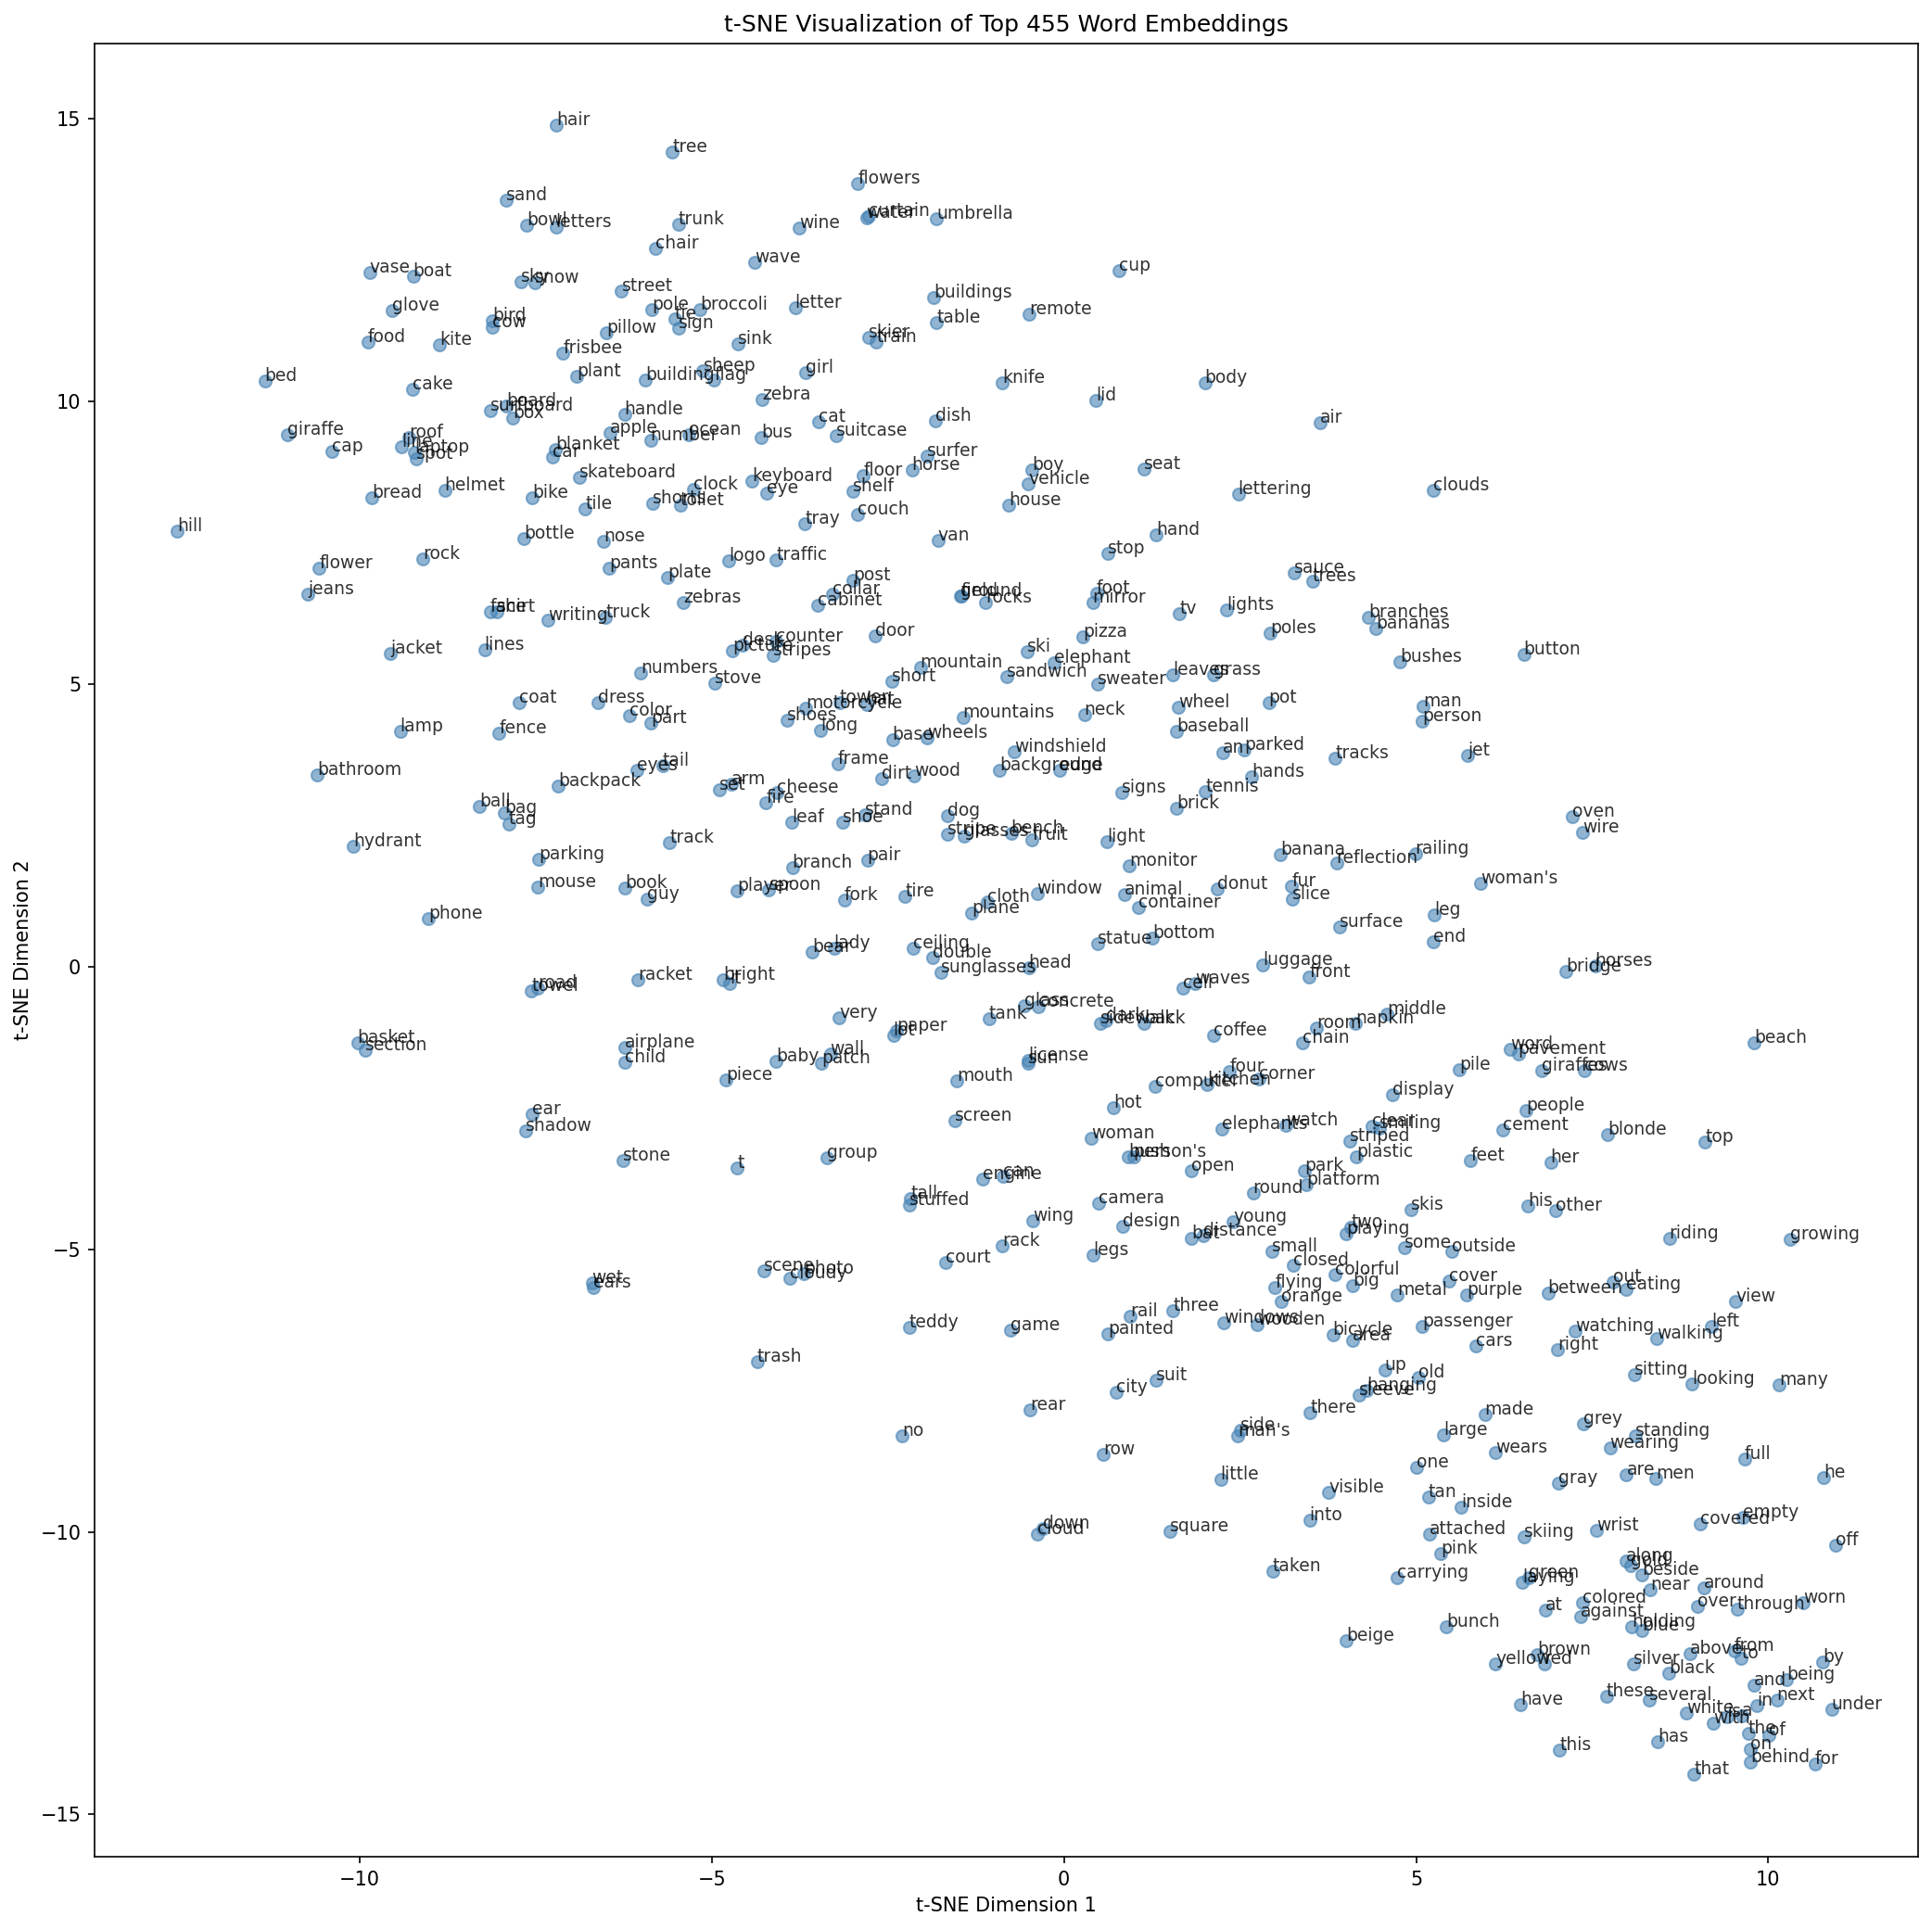

In [6]:
from lab6 import analyze_embeddings, visualize_embeddings, SkipGramModel
import torch
import os
import numpy as np
from IPython.display import Image, display

# --- 1. Load Best Model ---
# We load the model, nodes, and embeddings saved by train_embeddings
model_path = 'best_model.pth'
if os.path.exists(model_path):
    print(f"Loading best model from {model_path}...")
    checkpoint = torch.load(model_path)
    nodes = checkpoint['nodes']

    # Reconstruct model to get final (non-detached) embeddings
    # Note: We use .get_embeddings() which returns the center_embeddings
    model = SkipGramModel(checkpoint['vocab_size'], checkpoint['embedding_dim'])
    model.load_state_dict(checkpoint['model_state_dict'])
    embeddings = model.get_embeddings()

    print(f"✅ Loaded embeddings for {len(nodes):,} words")
else:
    print("❌ Error: No saved model found!")
    print("Please run the training cell above before proceeding.")
    # Raise an error to stop execution if the model is missing
    raise FileNotFoundError(f"{model_path} not found. Please train the model first.")

# --- 2. Qualitative Analysis ---
# Now we use the helper functions to probe what the model learned.
# We'll check for nearest neighbors (semantics) and analogies (linear structure).
analyze_embeddings(
    nodes=nodes,
    embeddings=embeddings,

    # --- Nearest neighbors ---
    # Probe visual semantics, attributes, and compositional structure
    similarity_examples=[
        # People and roles
        "man", "woman", "child", "boy", "girl", "person",
        # Scene elements
        "tree", "building", "sky", "street", "car", "table",
        # Colors and materials
        "red", "blue", "green", "black", "white", "wooden", "metal",
        # Actions
        "walking", "sitting", "holding", "riding", "standing",
        # Textures / objects
        "water", "grass", "sand", "snow", "wall"
    ],

    # --- Analogies ---
    # a : b :: c : ?
    #  → test if embedding geometry captures color, role, size, material, and action relations
    analogy_examples=[
        # Color analogies
        ("red", "apple", "yellow"),        # → banana?
        ("blue", "sky", "green"),          # → grass?
        ("white", "snow", "brown"),        # → dirt or wood?

        # Role analogies
        ("man", "woman", "boy"),           # → girl?
        ("boy", "girl", "man"),            # → woman?
        ("person", "hat", "hand"),         # → glove?

        # Size / quantity / attribute analogies
        ("long", "short", "tall"),         # → short?
        ("one", "two", "three"),           # → four?

        # Action and object use
        ("dog", "walking", "cat"),         # → sitting?
        ("person", "riding", "boat"),      # → sitting or water?
        ("pizza", "eating", "umbrella"),   # → holding?

        # Material / context
        ("metal", "car", "wooden"),        # → table?
        ("water", "boat", "road"),         # → car?
    ],

    # --- Semantic clusters ---
    # seeds chosen to reveal structure in scene-object relationships
    cluster_seeds=[
        "red", "blue", "green",          # color cluster
        "man", "woman", "child",         # human cluster
        "dog", "cat", "horse", "bird",   # animal cluster
        "building", "house", "street",   # architecture/scene
        "sky", "clouds", "water", "grass", # natural elements
        "car", "bus", "bicycle", "train" # vehicles
    ]
)

# --- 3. t-SNE Visualization ---
# We'll create a 2D plot of the *most frequent* words
# NOTE: Visualizing all 10k+ words is too slow and unreadable.
# The function defaults to the top 200, we'll use 300.
print("\n" + "="*80)
print("VISUALIZING EMBEDDINGS")
print("="*80)
print("Generating t-SNE plot for the top 300 words...")
print("(This may take a moment...)")

tsne_file = "embeddings_tsne.png"
visualize_embeddings(
    nodes,
    embeddings,
    output_file=tsne_file,
    sample_size=len(nodes),
    annotate=True
)

# Display the generated plot
if os.path.exists(tsne_file):
    print(f"\n📈 Displaying t-SNE visualization from {tsne_file}:")
    display(Image(filename=tsne_file, width=800))
else:
    print(f"\n(Plot file {tsne_file} not found.)")

In [7]:
from lab6 import run_tests

print("="*80)
print("🧪 RUNNING UNIT TESTS")
print("="*80)
print("This will test your implementations of SkipGramDataset and SkipGramModel.")
print("It's crucial that you test your implementations in this lab.")

# This function will run all tests defined in the lab6.py file
# Look for an "OK" or "PASSED" summary at the end.
success = run_tests()

print("\n" + "="*80)
if success:
    print("✅ All tests passed! You are ready to move on to the next step.")
else:
    print("❌ Some tests failed. Please review the errors above and fix your code.")
print("="*80)

test_contexts_built (lab6.TestSkipGramDataset)
Test that contexts are built correctly. ... ok
test_getitem_returns_triplet (lab6.TestSkipGramDataset)
Test that __getitem__ returns correct format. ... ok
test_pairs_generated (lab6.TestSkipGramDataset)
Test that pairs are generated. ... ok
test_embeddings_initialized (lab6.TestSkipGramModel)
Test that embeddings are initialized. ... ok
test_forward_returns_loss (lab6.TestSkipGramModel)
Test that forward pass returns loss. ... ok
test_get_embeddings_returns_numpy (lab6.TestSkipGramModel)
Test that get_embeddings returns numpy array. ... ok
test_dataset_model_compatibility (lab6.TestIntegration)
Test that dataset output works with model input. ... 

🧪 RUNNING UNIT TESTS
This will test your implementations of SkipGramDataset and SkipGramModel.
It's crucial that you test your implementations in this lab.
RUNNING SKIP-GRAM UNIT TESTS

✅ ALL TESTS PASSED!
Total tests run: 7

✅ All tests passed! You are ready to move on to the next step.


ok

----------------------------------------------------------------------
Ran 7 tests in 0.006s

OK
